In [1]:
pip install langchain

In [2]:
pip install gradio

In [3]:
pip install openai

In [4]:
pip install lancedb clip torch datasets pillow

In [5]:
pip install transformers

In [6]:
pip install open_clip_torch

In [11]:
import clip
import torch
import os
from datasets import load_dataset

ds = load_dataset("vipulmaheshwari/GTA-Image-Captioning-Dataset")


In [43]:
ds.data

In [8]:
 pip install git+https://github.com/openai/CLIP.git

  Cloning https://github.com/openai/CLIP.git to /tmp/pip-req-build-keay0n7a
  Running command git clone --filter=blob:none --quiet https://github.com/openai/CLIP.git /tmp/pip-req-build-keay0n7a
  Resolved https://github.com/openai/CLIP.git to commit a1d071733d7111c9c014f024669f959182114e33
  Preparing metadata (setup.py) ... done


In [13]:
device = torch.device("cpu")
model, preprocess = clip.load("ViT-L/14", device=device)


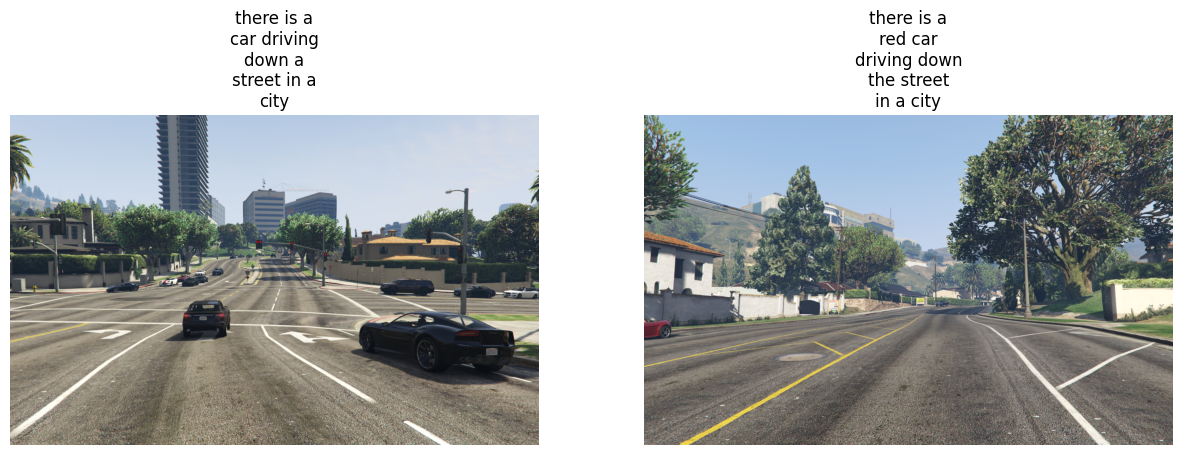

In [14]:
from textwrap import wrap
import matplotlib.pyplot as plt
import numpy as np

def plot_images(images, captions):
    plt.figure(figsize=(15, 7))
    for i in range(len(images)):
        ax = plt.subplot(1, len(images), i + 1)
        caption = captions[i]
        caption = "\n".join(wrap(caption, 12))
        plt.title(caption)
        plt.imshow(images[i])
        plt.axis("off")

# Assuming ds is a dictionary with "train" key containing a list of samples
sample_dataset = ds["train"]
random_indices = np.random.choice(len(sample_dataset), size=2, replace=False)
random_indices = [index.item() for index in random_indices]

# Get the random images and their captions
random_images = [np.array(sample_dataset[index]["image"]) for index in random_indices]
random_captions = [sample_dataset[index]["text"] for index in random_indices]

# Plot the random images with their captions
plot_images(random_images, random_captions)

# Show the plot
plt.show()

In [17]:
model

CLIP(
  (visual): VisionTransformer(
    (conv1): Conv2d(3, 1024, kernel_size=(14, 14), stride=(14, 14), bias=False)
    (ln_pre): LayerNorm((1024,), eps=1e-05, elementwise_affine=True)
    (transformer): Transformer(
      (resblocks): Sequential(
        (0): ResidualAttentionBlock(
          (attn): MultiheadAttention(
            (out_proj): NonDynamicallyQuantizableLinear(in_features=1024, out_features=1024, bias=True)
          )
          (ln_1): LayerNorm((1024,), eps=1e-05, elementwise_affine=True)
          (mlp): Sequential(
            (c_fc): Linear(in_features=1024, out_features=4096, bias=True)
            (gelu): QuickGELU()
            (c_proj): Linear(in_features=4096, out_features=1024, bias=True)
          )
          (ln_2): LayerNorm((1024,), eps=1e-05, elementwise_affine=True)
        )
        (1): ResidualAttentionBlock(
          (attn): MultiheadAttention(
            (out_proj): NonDynamicallyQuantizableLinear(in_features=1024, out_features=1024, bias=True)


In [18]:
preprocess


Compose(
    Resize(size=224, interpolation=bicubic, max_size=None, antialias=True)
    CenterCrop(size=(224, 224))
    <function _convert_image_to_rgb at 0x78b3bdefe170>
    ToTensor()
    Normalize(mean=(0.48145466, 0.4578275, 0.40821073), std=(0.26862954, 0.26130258, 0.27577711))
)

In [19]:
type(preprocess)

torchvision.transforms.transforms.Compose

In [36]:
import pyarrow as pa
import lancedb
import tqdm

db = lancedb.connect('./data/tables')
schema = pa.schema(
  [
      pa.field("vector", pa.list_(pa.float32(), 768)),
      pa.field("text", pa.string()),
      pa.field("id", pa.int32())
  ])
tbl = db.create_table("gta_data", schema=schema, mode="overwrite")

In [16]:
def embed_image(img):
    processed_image = preprocess(img)
    unsqueezed_image = processed_image.unsqueeze(0).to(device)
    embeddings = model.encode_image(unsqueezed_image)

    # Detach, move to CPU, convert to numpy array, and extract the first element as a list
    result = embeddings.detach().cpu().numpy()[0].tolist()
    return result

In [20]:
data = []
for i in range(len(ds["train"])):
    img = ds["train"][i]['image']
    text = ds["train"][i]['text']

    # Encode the image
    encoded_img = embed_image(img)
    data.append({"vector": encoded_img, "text": text, "id" : i})

In [26]:
type(data[0])

dict

In [22]:
tbl


LanceTable(connection=LanceDBConnection(/content/data/tables), name="gta_data")

In [32]:
len(data)

785

In [34]:
data[0]

{'vector': [0.9628681540489197,
  0.3573853373527527,
  -0.04923315718770027,
  -0.09236866980791092,
  -0.5975220203399658,
  0.8679186701774597,
  0.5611386299133301,
  0.5190132260322571,
  -0.33847713470458984,
  -0.9743854403495789,
  0.10866424441337585,
  -0.5149068236351013,
  -0.34354811906814575,
  -0.8508278131484985,
  0.4197852313518524,
  -0.35799846053123474,
  0.9759525656700134,
  -0.28956297039985657,
  -0.5018228888511658,
  0.13390089571475983,
  0.8915669322013855,
  -0.6352693438529968,
  -0.822182297706604,
  -0.45968231558799744,
  -0.013833273202180862,
  0.5225792527198792,
  0.39747416973114014,
  -0.04998723044991493,
  0.6319341659545898,
  -0.41904696822166443,
  0.2074364572763443,
  0.3363284170627594,
  0.4098629653453827,
  -0.09756524115800858,
  0.8581193685531616,
  0.17447978258132935,
  -0.15100523829460144,
  -0.4406832158565521,
  -0.31179001927375793,
  0.5841394662857056,
  0.5386597514152527,
  -0.21143019199371338,
  -0.706683874130249,
  -0

In [33]:
len(data[777]["vector"])

768

In [35]:
tbl.schema

vector: fixed_size_list<item: float>[512]
  child 0, item: float
text: string
id: int32

In [37]:
tbl.add(data=data)
tbl.to_pandas()

vector  \
0    [0.96286815, 0.35738534, -0.049233157, -0.0923...   
1    [1.1721082, 0.5741964, -0.11420482, -0.5107774...   
2    [0.8871585, 0.39471406, -0.16905549, -0.473860...   
3    [1.0490752, 0.3939149, -0.19399364, -0.6826567...   
4    [0.91442376, 0.51502097, -0.06846176, -0.70166...   
..                                                 ...   
780  [1.2268054, 0.16824776, 0.6206273, -0.9267596,...   
781  [1.2286305, 0.25344485, 0.64311785, -0.9299745...   
782  [1.2703046, 0.20788446, 0.66401196, -1.1403881...   
783  [1.3224317, 0.07376705, 0.505292, -1.1163472, ...   
784  [1.1436421, 0.05728818, 0.19484349, -1.1651787...   

                                                  text   id  
0    there is a man walking down a hill with a skat...    0  
1    there is a street with a yellow line on it and...    1  
2      there is a street with a sign on the side of it    2  
3    there is a picture of a street with a red car ...    3  
4    there is a street with a yellow sign on the si...    4  
..                                                 ...  ...  
780  there is a motorcycle that is driving down the...  780  
781     there is a truck that is driving down the road  781  
782   there is a road with a yellow line going down it  782  
783  there is a truck driving down the road in the ...  783  
784  there is a car driving down the road in the mo...  784  

[785 rows x 3 columns]

In [38]:
def embed_txt(txt):
    tokenized_text = clip.tokenize([txt]).to(device)
    embeddings = model.encode_text(tokenized_text)

    # Detach, move to CPU, convert to numpy array, and extract the first element as a list
    result = embeddings.detach().cpu().numpy()[0].tolist()
    return result

res = tbl.search(embed_txt("a road with a stop")).limit(3).to_pandas()
res

vector  \
0  [0.84217095, 0.3378302, 0.18648224, -0.4976399...   
1  [0.6762145, 0.05676798, 0.001483688, -0.382952...   
2  [0.92854786, 0.2881397, -0.37294272, -0.224128...   

                                                text   id   _distance  
0     there is a bus that is driving down the street  423  426.590515  
1  there is a truck driving down a street with a ...  569  435.230927  
2     there is a stop sign on the corner of a street  169  436.108032

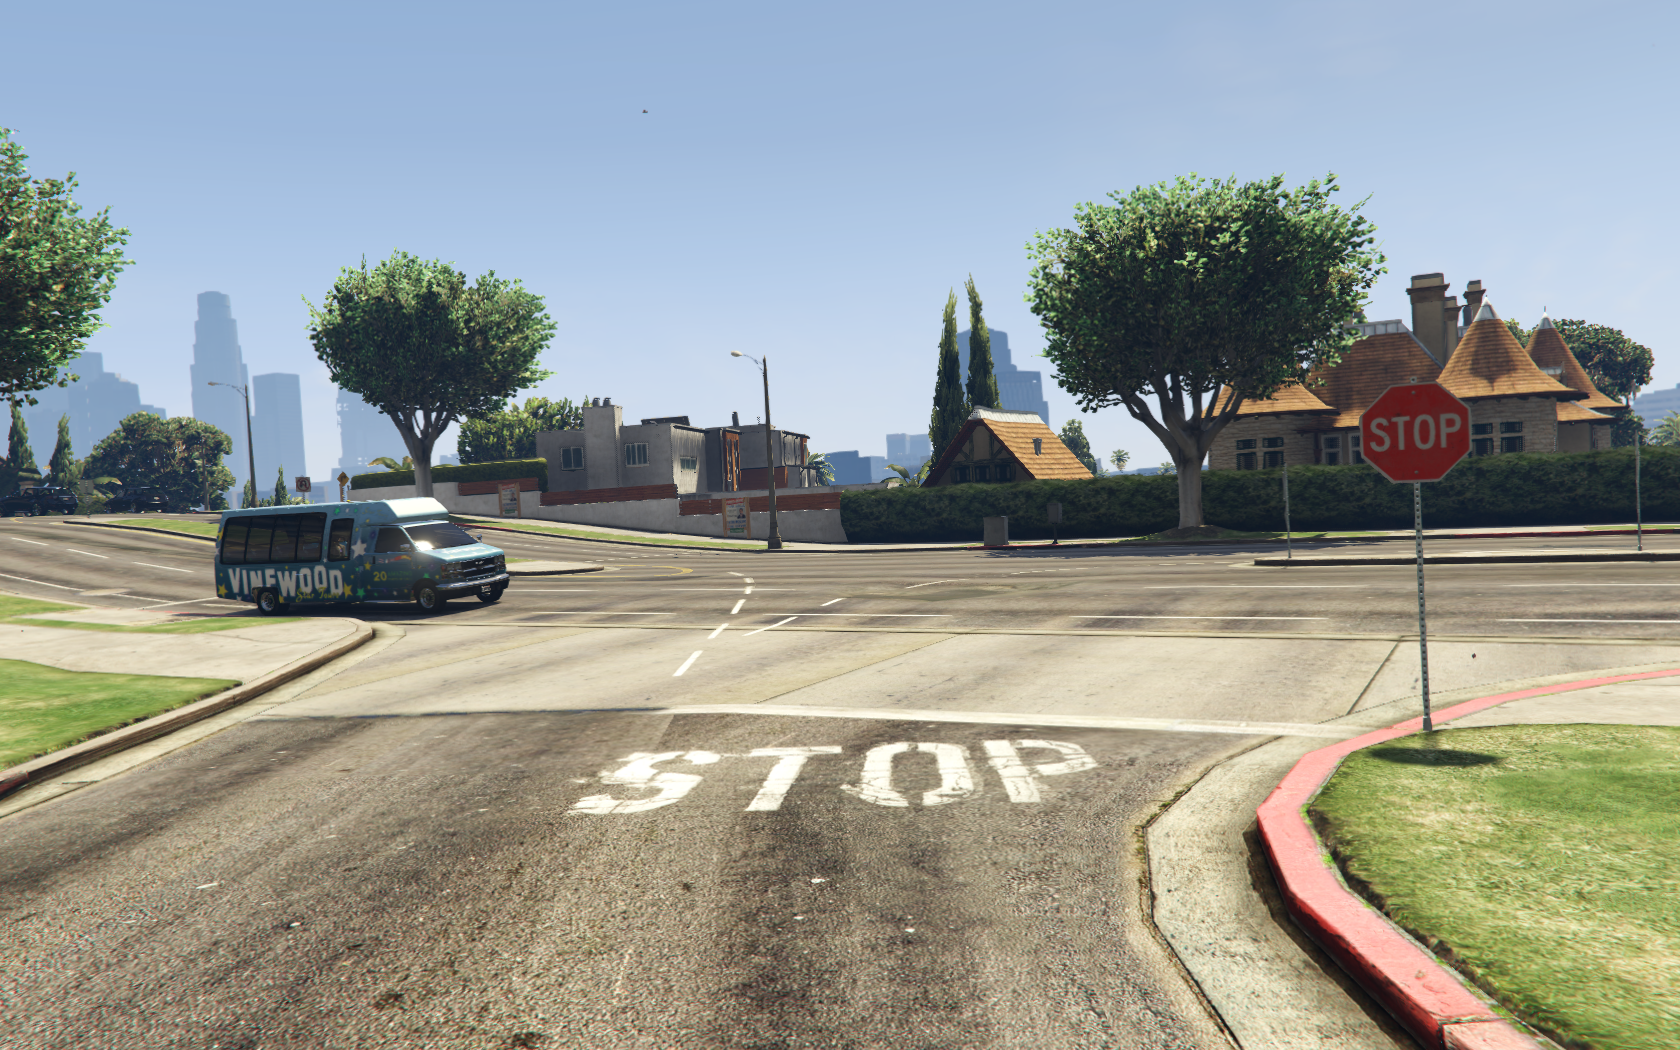

there is a bus that is driving down the street


In [39]:
data_id = int(res['id'][0])
display(ds["train"][data_id]['image'])
print(ds["train"][data_id]['text'])